In [51]:

# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import os
import sys
sys.path.append(os.path.abspath("./"))
import importlib
import cleaning
importlib.reload(cleaning)  # Force reload the module


# Modeling, Analysis, and Conclusion

In [20]:
df = pd.read_csv("../data/reddit_cleaned_df.csv")
df = df.drop(columns="Unnamed: 0")
df.head()

,post_id,title,selftext,subreddit,created_utc,is_osr
0,1irnln3,HeroQuest is the perfect intro to OSR.,HeroQuest is the perfect entry into OSR DND. ...,osr,1.739809e+09,1
1,1f3scds,"B/X is so intuitive, I don't have to really ""p...","To be clear, it was a lot of work before the g...",osr,1.724901e+09,1
2,1di0qn6,My most disappointing Kickstarter that filfilled,"So, I know there was a thread discussing peopl...",osr,1.718638e+09,1
3,1g5ga0h,Got the complete set off ebay for 80 bucks!,Really loving the booklet layout. Open up char...,osr,1.729131e+09,1
4,1grfhij,Castles & Crusades: Best Modern Edition of D&D...,In this video I discuss why I consider Castles...,osr,1.731619e+09,1


**Before processing the dataframe, I would like to add sentiment analysis, a word count, and text character count columns.  These will be useful in modeling the data.**

In [21]:
sa = SentimentIntensityAnalyzer()

sentiment_data = [sa.polarity_scores(text) for text in df["selftext"]]
sentiment_df = pd.DataFrame.from_dict(sentiment_data)
df = pd.concat([df, sentiment_df],axis=1)
df.head()

df["cleaned_selftext"] = df["selftext"].apply(cleaning.preprocess_selftext)
df["cleaned_title"] = df["title"].apply(cleaning.preprocess_selftext)

df["text_len"] = df["selftext"].str.len()
df["word_count"] = df["selftext"].str.split().apply(len)
df.head()

,post_id,title,selftext,subreddit,created_utc,is_osr,neg,neu,pos,compound,cleaned_selftext,cleaned_title,text_len,word_count
0,1irnln3,HeroQuest is the perfect intro to OSR.,HeroQuest is the perfect entry into OSR DND. ...,osr,1.739809e+09,1,0.118,0.708,0.174,0.5313,heroquest be the perfect entry into osr dnd . ...,heroquest be the perfect intro to osr .,213,36
1,1f3scds,"B/X is so intuitive, I don't have to really ""p...","To be clear, it was a lot of work before the g...",osr,1.724901e+09,1,0.094,0.760,0.147,0.9769,"to be clear , it be a lot of work before the g...","b/x be so intuitive , i do n't have to really ...",2434,441
2,1di0qn6,My most disappointing Kickstarter that filfilled,"So, I know there was a thread discussing peopl...",osr,1.718638e+09,1,0.066,0.859,0.075,0.3694,"so , i know there be a thread discussing peopl...",my most disappointing kickstarter that filfilled,899,166
3,1g5ga0h,Got the complete set off ebay for 80 bucks!,Really loving the booklet layout. Open up char...,osr,1.729131e+09,1,0.000,0.758,0.242,0.9237,really love the booklet layout . open up chara...,get the complete set off ebay for 80 buck !,313,50
4,1grfhij,Castles & Crusades: Best Modern Edition of D&D...,In this video I discuss why I consider Castles...,osr,1.731619e+09,1,0.000,0.701,0.299,0.5719,in this video i discuss why i consider castle ...,castle & crusade : best modern edition of d & ...,85,16


## Modeling

In [47]:
%%time
# with compound sentiment

X = df.drop(columns=["post_id"])

y = df["is_osr"]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y, 
                                                    random_state=123, 
                                                    train_size=0.25, 
                                                   stratify=y) 

#separate processing for text columns
title_transformer = Pipeline([
    ("flatten", FunctionTransformer(lambda x: x["cleaned_title"].values, validate=False)),    
    ("tfidf", TfidfVectorizer())
])

selftext_transformer = Pipeline([
    ("flatten", FunctionTransformer(lambda x: x["cleaned_selftext"].values, validate=False)),        
    ("tfidf", TfidfVectorizer())
])
# Numeric processing pipeline with standard scaler
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

title_column = ["cleaned_title"]
selftext_column = ["cleaned_selftext"]
num_columns = ["compound", "created_utc", "word_count"]

# preprocess in order to use both text and numerical data
preprocessor = ColumnTransformer([
    ("title", title_transformer, title_column),
    ("selftext", selftext_transformer, selftext_column),
    ("sentiment", numeric_transformer, num_columns)
])

# pipeline with LogReg 
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression())
])

param_grid = [
    # LogisticRegression
    {
        'preprocessor__selftext__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
        'preprocessor__selftext__tfidf__max_features': [500, 1000, 3000, None],
        'preprocessor__title__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
        'preprocessor__title__tfidf__max_features': [500, 1000, 3000, None],
        'model': [LogisticRegression()],
        'model__C': [0.1, 1, 10],
    },
    # RandomForestClassifier
    {
        'preprocessor__selftext__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
        'preprocessor__selftext__tfidf__max_features': [500, 1000, 3000, None],
        'preprocessor__title__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
        'preprocessor__title__tfidf__max_features': [500, 1000, 3000, None],
        'model': [RandomForestClassifier()],  
        'model__n_estimators': [50, 100, 500],
        'model__max_depth': [3, 5, None],
        'model__max_features': ['sqrt', "log2", 3]

    }
]

grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Score:", grid.best_score_)
print("Best Params:", grid.best_params_)

best_estimator = grid.best_estimator_


/Users/bolanle/Desktop/dsb-210/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Score: 0.8146017699115043
Best Params: {'model': LogisticRegression(), 'model__C': 10, 'preprocessor__selftext__tfidf__max_features': 3000, 'preprocessor__selftext__tfidf__ngram_range': (1, 2), 'preprocessor__title__tfidf__max_features': 3000, 'preprocessor__title__tfidf__ngram_range': (1, 1)}
Training Score of Best Estimator: 0.8226571767497034
CPU times: user 1min 14s, sys: 26.5 s, total: 1min 41s
Wall time: 26min 38s


In [48]:
train_score = best_estimator.score(X_train, y_train)
test_score = best_estimator.score(X_test, y_test)
print("Training Score of Best Estimator:", train_score)
print("Test Score of Best Estimator:", test_score)

Training Score of Best Estimator: 1.0
Test Score of Best Estimator: 0.8226571767497034


**I'm going to try the same grid search, just with one column switched out. I don't want to run the risk of my model on converging by putting both negative sentiment and compound sentiment together. If they are collinearly related, this would create issues.**

In [85]:
%%time
#with negative sentiment

X = df.drop(columns=["post_id"])

y = df["is_osr"]


#separate processing for text columns
title_transformer = Pipeline([
    ("flatten", FunctionTransformer(lambda x: x["cleaned_title"].values, validate=False)),    
    ("tfidf", TfidfVectorizer())
])

selftext_transformer = Pipeline([
    ("flatten", FunctionTransformer(lambda x: x["cleaned_selftext"].values, validate=False)),        
    ("tfidf", TfidfVectorizer())
])
# Numeric processing pipeline with standard scaler
numeric_transformer = Pipeline([
    ("scaler", StandardScaler())
])

title_column = ["cleaned_title"]
selftext_column = ["cleaned_selftext"]
num_columns = ["neg", "created_utc", "word_count"]

# preprocess in order to use both text and numerical data
preprocessor = ColumnTransformer([
    ("title", title_transformer, title_column),
    ("selftext", selftext_transformer, selftext_column),
    ("sentiment", numeric_transformer, num_columns)
])

# pipeline with LogReg 
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression())
])

param_grid = [
    # LogisticRegression
    {
        'preprocessor__selftext__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
        'preprocessor__selftext__tfidf__max_features': [500, 1000, 3000, None],
        'preprocessor__title__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
        'preprocessor__title__tfidf__max_features': [500, 1000, 3000, None],
        'model': [LogisticRegression()],
        'model__C': [0.1, 1, 10],
    },
    # RandomForestClassifier
    {
        'preprocessor__selftext__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
        'preprocessor__selftext__tfidf__max_features': [500, 1000, 3000, None],
        'preprocessor__title__tfidf__ngram_range': [(1,1), (1,2), (1,3)],
        'preprocessor__title__tfidf__max_features': [500, 1000, 3000, None],
        'model': [RandomForestClassifier()],  
        'model__n_estimators': [50, 100, 500],
        'model__max_depth': [3, 5, None],
        'model__max_features': ['sqrt', "log2", 3]

    }
]

grid1 = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
grid1.fit(X_train, y_train)

print("Best Score:", grid1.best_score_)
print("Best Params:", grid1.best_params_)

best_estimator1 = grid1.best_estimator_


Best Score: 0.8199115044247789
Best Params: {'model': RandomForestClassifier(), 'model__max_depth': None, 'model__max_features': 'sqrt', 'model__n_estimators': 100, 'preprocessor__selftext__tfidf__max_features': 1000, 'preprocessor__selftext__tfidf__ngram_range': (1, 1), 'preprocessor__title__tfidf__max_features': 500, 'preprocessor__title__tfidf__ngram_range': (1, 1)}
CPU times: user 1min 14s, sys: 25 s, total: 1min 39s
Wall time: 26min 12s


In [86]:
train_score = best_estimator1.score(X_train, y_train)
test_score = best_estimator1.score(X_test, y_test)
print("Training Score of Best Estimator:", train_score)
print("Test Score of Best Estimator:", test_score)

Training Score of Best Estimator: 1.0
Test Score of Best Estimator: 0.8202846975088968


## Analysis

### Winning Model: Logistic Regression
**The best model is LogisticRegression, though it is very overfit.**

I am choosing this over the Random Forest Classifier because, though they are both overfit, the Logistic Regression has a slightly better testing score. Additionally, the Logistic Regression will be easier to explain to my audience. 

In [60]:
%%time

param_grid = [
    # LogisticRegression
    {
        'preprocessor__selftext__tfidf__ngram_range': [(1,2)],
        'preprocessor__selftext__tfidf__max_features': [3000],
        'preprocessor__title__tfidf__ngram_range': [(1,1)],
        'preprocessor__title__tfidf__max_features': [3000],
        'model': [LogisticRegression()],
        'model__C': [10]
    }
]
log_grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)
log_grid.fit(X_train, y_train)

CPU times: user 187 ms, sys: 127 ms, total: 315 ms
Wall time: 1.43 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('title',
                                                                         Pipeline(steps=[('flatten',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x10b6a2fc0>)),
                                                                                         ('tfidf',
                                                                                          TfidfVectorizer())]),
                                                                         ['cleaned_title']),
                                                                        ('selftext',
                                                                         Pipeline(steps=[('flatten',
                                                                                          FunctionTransformer(func=<function <lambda> at 0x118b73420>)),
                                                                                         ('tfidf',
                                                                                          TfidfVe...
                                                                                          StandardScaler())]),
                                                                         ['compound',
                                                                          'created_utc'])])),
                                       ('model', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [LogisticRegression()], 'model__C': [10],
                          'preprocessor__selftext__tfidf__max_features': [3000],
                          'preprocessor__selftext__tfidf__ngram_range': [(1,
                                                                          2)],
                          'preprocessor__title__tfidf__max_features': [3000],
                          'preprocessor__title__tfidf__ngram_range': [(1, 1)]}])

In [61]:
log_grid.score(X_train, y_train), log_grid.score(X_test, y_test)

(1.0, 0.8291814946619217)

**We can see our score for the Logistic Regression is about 83% which, since we are solving a classification problem, means that our model is 83% accurate in making a correct prediction.**

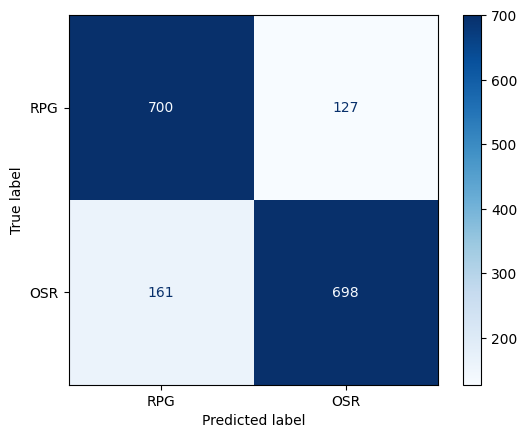

In [83]:
y_test_preds = log_grid.predict(X_test)
confuse_mat = metrics.confusion_matrix(y_test, y_test_preds)
display = metrics.ConfusionMatrixDisplay(confusion_matrix=confuse_mat, display_labels=["RPG", "OSR"])
display.plot(cmap=plt.cm.Blues)
plt.show()
plt.title()8~

In [68]:
print(metrics.classification_report(y_test, y_test_preds, digits = 3))

              precision    recall  f1-score   support

           0      0.813     0.846     0.829       827
           1      0.846     0.813     0.829       859

    accuracy                          0.829      1686
   macro avg      0.830     0.830     0.829      1686
weighted avg      0.830     0.829     0.829      1686



### Confusion Matrix and Metrics
700 times, the model predicted that a document was ***not*** from the OSR subreddit (and therefore from the  RPG subreddit), and was correct. 161 times, the model predicted a document was not from the OSR subreddit and it was (so an incorrect prediction).

Conversely, 698 times the model predicted a document was from the OSR subreddit correctly. 127 times the model predicted a document to be from the OSR and it was from the RPG subreddit.

Overall, we have an F1 score of ~83%. There's a preference for using F1 score here because it takes into account both the precision and sensitivity (recall).

On the whole, the final model yielded encouraging results, achieving an accuracy of approximately 83%, which is a significant improvement over the baseline of around 51%. This indicates that the model was able to meaningfully distinguish between posts from the two communities. Importantly, through EDA we were also able to highlight quantifiably significant phrases such as “B/X,” “Old School Essentials,” “System,” and “Rules” — terms that offer insight into what each community prioritizes in its discussions and preferences. However, the model is not infallible; its 17% error rate reflects the natural overlap between the communities. Many users who participate in or enjoy OSR-style role-playing games also engage with broader RPG content, making it difficult to draw a strict boundary between the two groups. This intrinsic crossover of interests and shared terminology limits the ceiling for any classifier, suggesting that while useful distinctions can be drawn, a "perfect" model may not be feasible — and perhaps not desirable, given the fluidity of community engagement.

## Recommendations

#### Reference Familiar OSR Titles or Systems
Terms like “Old School Essentials”, “B/X”, and “Basic Fantasy” frequently surface. By explicitly connecting your game to these well-known systems—either highlighting similarities in tone/mechanics or clarifying how your game differs—you can tap into the existing conversation around popular OSR frameworks.

#### Emphasize Mechanics, Rules, and Gameplay
Unigrams such as “rules”, “system”, and “campaign” rank highly, suggesting that players in these communities care deeply about the structure and style of gameplay. Be prepared to showcase how your rule system supports an “old school” approach—e.g., simplicity, modularity, random tables, or robust character creation.

#### Leverage the Community’s Keywords
Terms like “osr games,” “osr style,” “dungeon,” and “magic items” show that OSR fans gravitate toward specific tropes (e.g., traditional dungeon-crawling, distinctive loot, and resource management). Position your marketing and pitch decks around these thematic anchors to signal you speak their language.

#### Consider Additional Research in Document Sentiment where Significant Words Appear 
A valuable next step would be to conduct a follow-up study examining how these frequently occurring bigrams and unigrams are actually discussed within the community. Specifically, one could run a sentiment analysis on the subsets of documents that feature each quantifiably significant term or phrase, gauging the average sentiment (positive, neutral, or negative) toward concepts like “Old School Essentials” or “5e.” This approach would move beyond mere statistical importance to offer a rough approximation of whether users like or dislike those concepts in practice. By cross-referencing sentiment scores with weighted term frequency, developers and researchers alike could gain a more nuanced view of community attitudes and use these insights to refine game design, messaging, and market positioning.
